# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Deep Learning Para Aplicações de IA com PyTorch e Lightning</font>

## <font color='blue'>Lab 2 - Parte 2</font>
## <font color='blue'>Regressão Logística x Torchvision Para Reconhecimento de Imagens</font>

Obs: Este Jupyter Notebook DEVE ser executado no ambiente em nuvem, como demonstrado nas aulas a seguir. 

## Instalando e Carregando os Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.8.16


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [3]:
!pip install -q torch==1.13.0

In [4]:
!pip install -q pytorch-lightning==1.8.3

In [5]:
!pip install -q lightning-bolts

In [6]:
# Imports
import math
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import gc
import types
import pkg_resources
import pytorch_lightning as pl

In [7]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

torch            : 1.13.0+cu116
numpy            : 1.21.6
pytorch_lightning: 1.8.3
matplotlib       : 3.2.2



## Verificando o Ambiente de Desenvolvimento

In [8]:
# Relatório completo

# Verificando o dispositivo
processing_device = "cuda" if torch.cuda.is_available() else "cpu"

# Verificando se GPU pode ser usada (isso depende da plataforma CUDA estar instalada)
torch_aval = torch.cuda.is_available()

# Labels para o relatório de verificação
lable_1 = 'Visão Geral do Ambiente'
lable_2 = 'Se NVIDIA-SMI não for encontrado, então CUDA não está disponível'
lable_3 = 'Fim da Checagem'

# Função para verificar o que está importado nesta sessão
def get_imports():

    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):            
            name = val.__module__.split(".")[0]

        poorly_named_packages = {"PIL": "Pillow", "sklearn": "scikit-learn"}

        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

# Imports nesta sessão
imports = list(set(get_imports()))

# Loop para verificar os requerimentos
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))
        
# Pasta com os dados (quando necessário)
pasta_dados = r'dados'

print(f'{lable_1:-^100}')
print()
print(f"Device:", processing_device)
print(f"Pasta de Dados: ", pasta_dados)
print(f"Versões dos Pacotes Requeridos: ", requirements)
print(f"Dispositivo Que Será Usado Para Treinar o Modelo: ", processing_device)
print(f"CUDA Está Disponível? ", torch_aval)
print("Versão do PyTorch: ", torch.__version__)
print("Versão do Lightning: ", pl.__version__)
print()
print(f'{lable_2:-^100}\n')
!nvidia-smi
gc.collect()
print()
print(f"Limpando a Memória da GPU (se disponível): ", torch.cuda.empty_cache())
print(f'\n{lable_3:-^100}')

--------------------------------------Visão Geral do Ambiente---------------------------------------

Device: cuda
Pasta de Dados:  dados
Versões dos Pacotes Requeridos:  [('torch', '1.13.0+cu116'), ('numpy', '1.21.6'), ('matplotlib', '3.2.2')]
Dispositivo Que Será Usado Para Treinar o Modelo:  cuda
CUDA Está Disponível?  True
Versão do PyTorch:  1.13.0+cu116
Versão do Lightning:  1.8.3

------------------Se NVIDIA-SMI não for encontrado, então CUDA não está disponível------------------

Tue Dec 27 06:02:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG 

In [9]:
import platform
print(platform.platform())

Linux-5.10.133+-x86_64-with-glibc2.27


In [10]:
# Define o device (GPU ou CPU)
device = torch.device(processing_device)
print(device)

cuda


In [11]:
# Imports
import os
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from IPython import display
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, update_bn
from torchmetrics.classification import Accuracy

/usr/local/lib/python3.8/dist-packages/pl_bolts/callbacks/data_monitor.py:20: UnderReviewWarning: The feature warn_missing_pkg is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  warn_missing_pkg("wandb")
/usr/local/lib/python3.8/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.8/dist-packages/pl_bolts/models/self_supervised

In [12]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

seaborn          : 0.11.2
torch            : 1.13.0+cu116
numpy            : 1.21.6
pytorch_lightning: 1.8.3
matplotlib       : 3.2.2
platform         : 1.0.8
IPython          : 7.9.0
pandas           : 1.3.5
torchvision      : 0.14.0+cu116



In [13]:
# Seed para inicializar o processo randômico com o mesmo padrão
seed_everything(7)

INFO:lightning_lite.utilities.seed:Global seed set to 7


7

In [14]:
# Pasta para gravar os datasets
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")

In [15]:
# Definimos o tamanho do batch de imagens de acordo com o hardware
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

In [16]:
# Número de workers
NUM_WORKERS = int(os.cpu_count() / 2)

In [17]:
# Módulo de transformações nos dados de treino (Data Loader de Treino)
prep_dados_treino = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding = 4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

In [18]:
# Módulo de transformações nos dados de teste (teste após o treinamento) e validação (teste durante o treinamento)
prep_dados_teste = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

In [19]:
# Módulo para carregar os dados e aplicar os data loaders
carrega_dados = CIFAR10DataModule(data_dir = PATH_DATASETS,
                                  batch_size = BATCH_SIZE,
                                  num_workers = NUM_WORKERS,
                                  train_transforms = prep_dados_treino,
                                  test_transforms = prep_dados_teste,
                                  val_transforms = prep_dados_teste)

In [20]:
# Módulo para carregar um modelo pré-treinado de arquitetura ResNet sem os pesos (queremos somente a arquitetura)
def carrega_modelo_pretreinado():
    modelo = torchvision.models.resnet18(weights = None, num_classes = 10)
    modelo.conv1 = nn.Conv2d(3, 64, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1), bias = False)
    modelo.maxpool = nn.Identity()
    return modelo

In [21]:
# Classe com Arquitetura do Modelo
class ModeloResnet(LightningModule):
    
    # Método construtor
    def __init__(self, lr = 0.05):
        super().__init__()
        self.save_hyperparameters()
        self.model = carrega_modelo_pretreinado()

    # Método Forward
    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim = 1)

    # Método de um passo de treinamento
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    # Método de avaliação
    def evaluate(self, batch, stage = None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim = 1)
        accuracy = Accuracy(task = "multiclass", num_classes = 10).to(device)
        acc = accuracy(preds, y)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar = True)
            self.log(f"{stage}_acc", acc, prog_bar = True)

    # Método de um passo de validação
    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    # Método de um passo de teste
    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    # Método de configuração do otimizador
    def configure_optimizers(self):
        
        # Otimização SGD
        optimizer = torch.optim.SGD(self.parameters(), 
                                    lr = self.hparams.lr, 
                                    momentum = 0.9, 
                                    weight_decay = 5e-4)
        
        # Passos por época
        steps_per_epoch = 45000 // BATCH_SIZE
        
        # Scheduler
        scheduler_dict = {
            "scheduler": OneCycleLR(optimizer,
                                    0.1,
                                    epochs = self.trainer.max_epochs,
                                    steps_per_epoch = steps_per_epoch),
            "interval": "step",
        }
        
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

In [22]:
# Cria o modelo (Objeto = Instância da Classe)
modelo_dl = ModeloResnet(lr = 0.05)

In [23]:
# Módulo de treinamento
treinador = Trainer(max_epochs = 30,
                    accelerator = "auto",
                    devices = 1 if torch.cuda.is_available() else None,  
                    logger = CSVLogger(save_dir = "logs/"),
                    callbacks = [LearningRateMonitor(logging_interval = "step"), 
                                 TQDMProgressBar(refresh_rate = 10)],
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [24]:
# Treinamento
treinador.fit(modelo_dl, carrega_dados)

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [25]:
# Avaliação do Modelo
treinador.test(modelo_dl, datamodule = carrega_dados)

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9207000136375427
        test_loss           0.27958178520202637
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.27958178520202637, 'test_acc': 0.9207000136375427}]

In [26]:
# Conseguimos performance bem superior ao modelo com Regressão Logística.

In [27]:
# Carrega as métricas
metricas = pd.read_csv(f"{treinador.logger.log_dir}/metrics.csv")

In [28]:
# Deleta os passos individuais
del metricas["step"]

In [29]:
# Ajusta o índice
metricas.set_index("epoch", inplace = True)

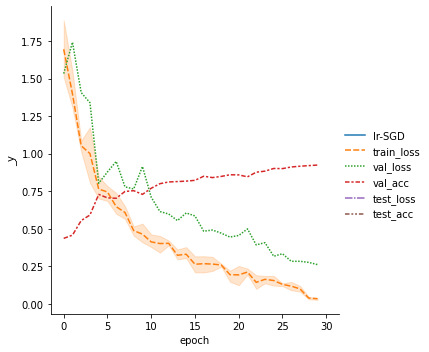

In [30]:
# Resultado
sn.relplot(data = metricas, kind = "line")

In [31]:
# Salvando o modelo 
torch.save(modelo_dl.state_dict(), 'modelo_dl.pth')

In [32]:
# Download do arquivo
from google.colab import files
files.download('modelo_dl.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
# Para carregar o modelo salvo no Google Colab
modelo_final_1 = torch.load('modelo_dl.pth')

In [34]:
print(modelo_final_1.keys())

odict_keys(['model.conv1.weight', 'model.bn1.weight', 'model.bn1.bias', 'model.bn1.running_mean', 'model.bn1.running_var', 'model.bn1.num_batches_tracked', 'model.layer1.0.conv1.weight', 'model.layer1.0.bn1.weight', 'model.layer1.0.bn1.bias', 'model.layer1.0.bn1.running_mean', 'model.layer1.0.bn1.running_var', 'model.layer1.0.bn1.num_batches_tracked', 'model.layer1.0.conv2.weight', 'model.layer1.0.bn2.weight', 'model.layer1.0.bn2.bias', 'model.layer1.0.bn2.running_mean', 'model.layer1.0.bn2.running_var', 'model.layer1.0.bn2.num_batches_tracked', 'model.layer1.1.conv1.weight', 'model.layer1.1.bn1.weight', 'model.layer1.1.bn1.bias', 'model.layer1.1.bn1.running_mean', 'model.layer1.1.bn1.running_var', 'model.layer1.1.bn1.num_batches_tracked', 'model.layer1.1.conv2.weight', 'model.layer1.1.bn2.weight', 'model.layer1.1.bn2.bias', 'model.layer1.1.bn2.running_mean', 'model.layer1.1.bn2.running_var', 'model.layer1.1.bn2.num_batches_tracked', 'model.layer2.0.conv1.weight', 'model.layer2.0.bn1.w

In [35]:
# Para carregar o modelo salvo em disco
files.upload()

Saving modelo_dl.pth to modelo_dl (1).pth


In [36]:
# Para carregar o modelo salvo no Google Colab
modelo_final_2 = torch.load('modelo_dl.pth')

In [37]:
print(modelo_final_2.keys())

odict_keys(['model.conv1.weight', 'model.bn1.weight', 'model.bn1.bias', 'model.bn1.running_mean', 'model.bn1.running_var', 'model.bn1.num_batches_tracked', 'model.layer1.0.conv1.weight', 'model.layer1.0.bn1.weight', 'model.layer1.0.bn1.bias', 'model.layer1.0.bn1.running_mean', 'model.layer1.0.bn1.running_var', 'model.layer1.0.bn1.num_batches_tracked', 'model.layer1.0.conv2.weight', 'model.layer1.0.bn2.weight', 'model.layer1.0.bn2.bias', 'model.layer1.0.bn2.running_mean', 'model.layer1.0.bn2.running_var', 'model.layer1.0.bn2.num_batches_tracked', 'model.layer1.1.conv1.weight', 'model.layer1.1.bn1.weight', 'model.layer1.1.bn1.bias', 'model.layer1.1.bn1.running_mean', 'model.layer1.1.bn1.running_var', 'model.layer1.1.bn1.num_batches_tracked', 'model.layer1.1.conv2.weight', 'model.layer1.1.bn2.weight', 'model.layer1.1.bn2.bias', 'model.layer1.1.bn2.running_mean', 'model.layer1.1.bn2.running_var', 'model.layer1.1.bn2.num_batches_tracked', 'model.layer2.0.conv1.weight', 'model.layer2.0.bn1.w

# Fim